In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl
%pip install folium
%pip install html2image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

### Base Config👾

In [3]:
#cspell:disable
from models.components import Tech,Component
from models.inventory import Building, Project


project:Project = Project(
    title='Sistema PV MHNV',
    connection_type='offgrid',
    building = Building(
        geolocation=(-33.047016, -71.621509),
        name='Edificio C_Porter MHNV',
        address='Calle Condell 1546',
        city='Valparaíso'),
    technology= [Tech.PHOTOVOLTAIC],
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.047016&longitude=-71.621509&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Pesos chileno.. on USD$0.00 
set $1 UF............. on USD$38.83 
set $1 UTM............ on USD$68.04 
set $1 Euro........... on USD$1.04 
set $1 Pound.......... on USD$1.25 
set $1 Real........... on USD$0.16 


### Consumptions && bills 🔌

In [4]:
from models.consumption import ElectricityBill as EB
from models.econometrics import Currency as C

project.building.add_consumptions(
    cost_increment=8,
    client_id='642180-6',
    measurer_id='10025437',
    contract_id='BT-3 PPP',
    consumption=[
        EB("04-01-2023","01-02-2023",1051,97_36_1,C.CLP,('BT','_3','PPP')),
        EB("02-02-2023","02-03-2023",1123,104_031,C.CLP,('BT','_3','PPP')),
        EB("03-03-2023","03-04-2023",1157,107_181,C.CLP,('BT','_3','PPP')),
        EB("04-04-2023","04-05-2023",1220,137_911,C.CLP,('BT','_3','PPP')),
        EB("05-05-2023","01-06-2023",1299,146_841,C.CLP,('BT','_3','PPP')),
        EB("02-06-2023","04-07-2023",1549,175_101,C.CLP,('BT','_3','PPP')),
        EB("05-07-2023","02-08-2023",1353,152_946,C.CLP,('BT','_3','PPP')),
        EB("03-08-2023","01-09-2023",1420,160_519,C.CLP,('BT','_3','PPP')),
        EB("02-09-2023","03-10-2023",1283,145_033,C.CLP,('BT','_3','PPP')),
        EB("04-10-2023","03-11-2023",1275,144_128,C.CLP,('BT','_3','PPP')),
        EB("04-11-2023","03-12-2023",1346,152_155,C.CLP,('BT','_3','PPP')),
        EB("04-12-2023","03-01-2024",1346,162_554,C.CLP,('BT','_3','PPP')),
    ]
)

# Integration 

### Machine Components 🎡

In [5]:
#cspell: disable
#repository of reusable components
from libs.repository import repoEquipment,panelRepo
from models.components import Specs
from models.econometrics import Currency,Cost
from models.geometry import Orientation
#clean previous load
project.components = {}
from IPython.display import clear_output

from models.photovoltaic import PvInput
clear_output(wait=True)

# assembly projects components
project.add_generator(
    panelRepo['CS 655W'],# equipment
    PvInput(
        description='FV 655W MOD 01',
        quantity=9,
        orientation=Orientation(35,28),
        ),
    PvInput(
        description='FV 655W MOD 02',
        quantity=11,
        orientation=Orientation(20,28),
        ),
    # PvInput(
    #     description='FV 655W MOD 03',
    #     quantity=4,
    #     orientation=Orientation(10,28),
    # )
    
)

#nominal power
pj_power = project.nominal_power

# Energy process
project.add_component(
    'instalación',
    repoEquipment['Inverter']['DY 12kW H'],# inverter
    repoEquipment['Medidor']['FR 3F'],# lectura
    Component(
    description='eléctrica interior',
    specification=Specs(
        category='Obra',
        brand='conexionado',
        model='interiores'
        ),
    cost_per_unit=Cost(225_000,currency=Currency.CLP),
    quantity=int(project.nominal_power[0])
    ),
Component(
    description='est. de montaje',
    specification=Specs(
        category='Montaje',
        montaje='coplanar',
        ),
    cost_per_unit=Cost(45_000,Currency.CLP),
    quantity=project.n_generator
    ),
)

# BESS & Storage
project.add_storage(
    'almacenamiento',4,'8/5',
    repoEquipment['Monitor']['VC 700'],
    repoEquipment['Regulator']['VT 45A']
    )

# obras y accesorios
project.add_component(
    'Obras',
    Component(
        description='Faenas',
        specification=Specs(
            category='Obra',
            brand='equipamiento',
            model='provisorio'),
        cost_per_unit=Cost(18_750,Currency.CLP),
        quantity=project.n_generator
        ),
    Component(
        description='Capacitación',
        specification=Specs(
            category='Obra',
            brand='Uso y',
            model='mantenimiento',
            taller='2 Hrs',
            manual='3 u. impreso',
            ),
        cost_per_unit=Cost(250_000,Currency.CLP),
        ),
    Component(
        description='Letrero',
        specification=Specs(
            category='Obra',
            brand='pliego',
            model='estructura',
            specs_url='#pliegos-técnicos',
            dim='3.6m x 1.5m',
            ),
        cost_per_unit=Cost(450_000,Currency.CLP),
        )
)

inside cost pv :  208547.06 Currency.CLP
inside cost pv :  208547.06 Currency.CLP


In [6]:
#Define bucket overloads
project.bucket.set_overloads(gastos_gral=15,utilidad=10)

In [17]:
project.connection_type = 'hybrid'

# Write Document 📒


c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:213: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:213: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


plot_done
replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux
replaced plot: map_location
work <models.inventory.Project object at 0x00000229AC60C6E0> finish at:  2024-12-26 16:57:44.911683


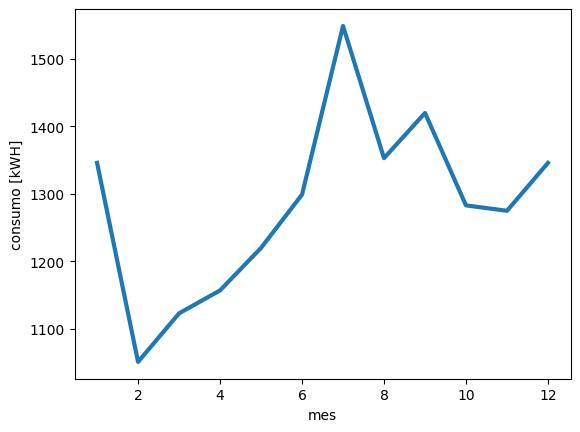

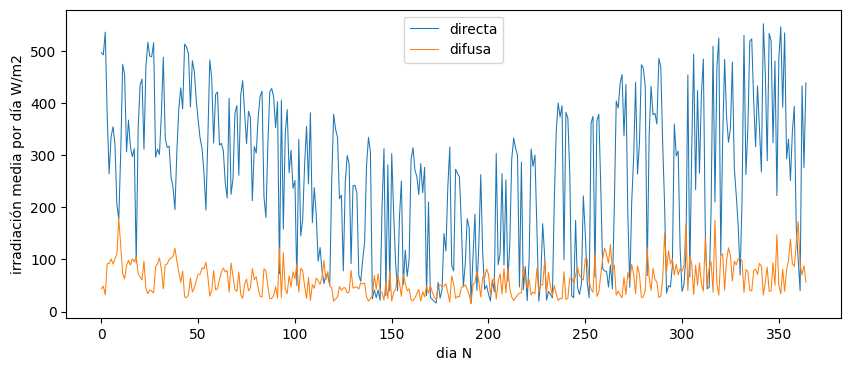

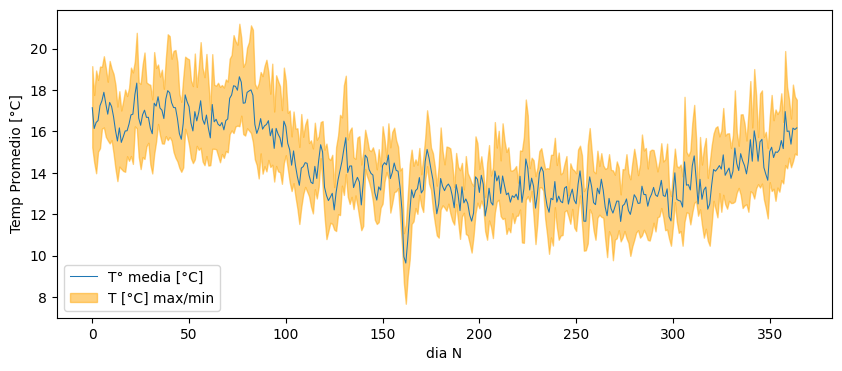

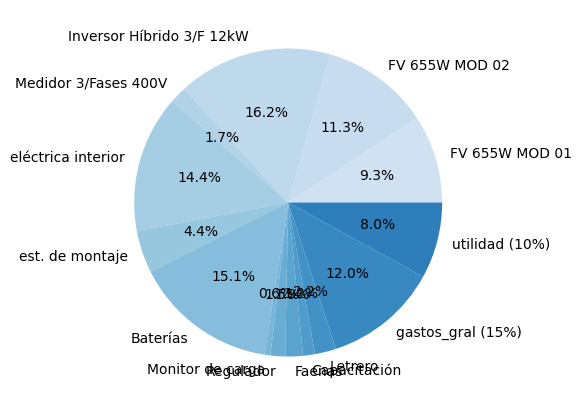

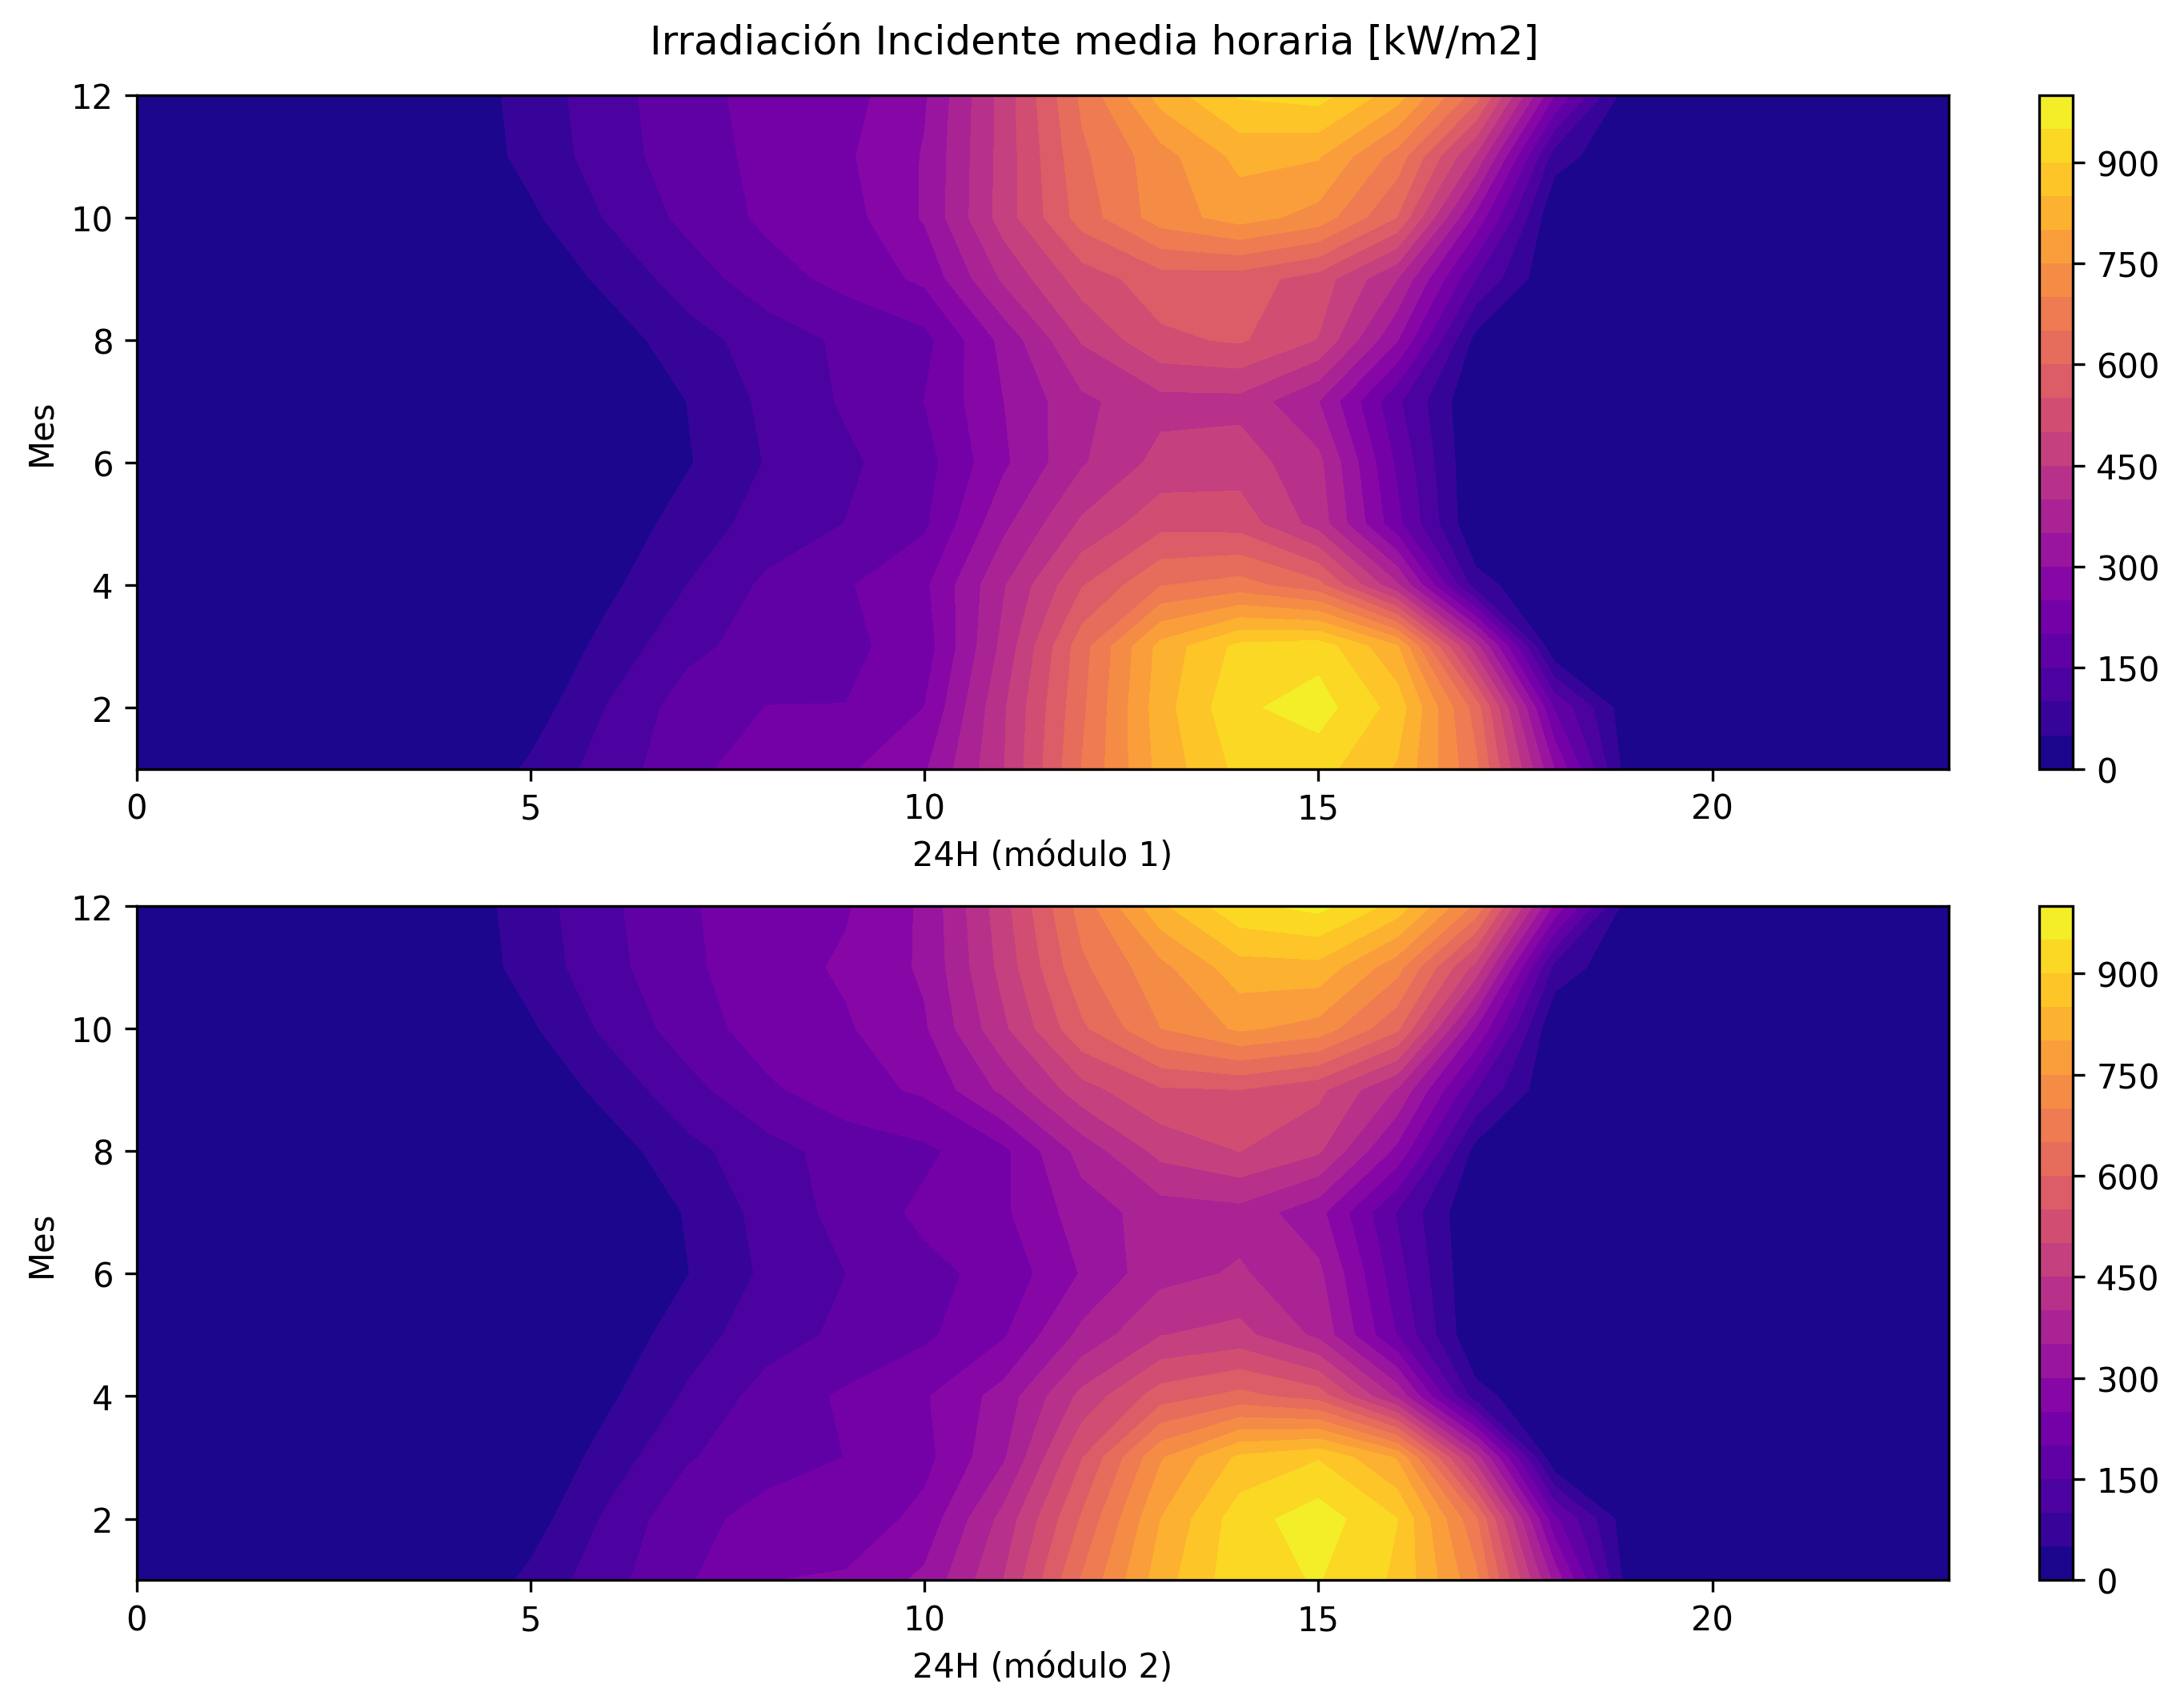

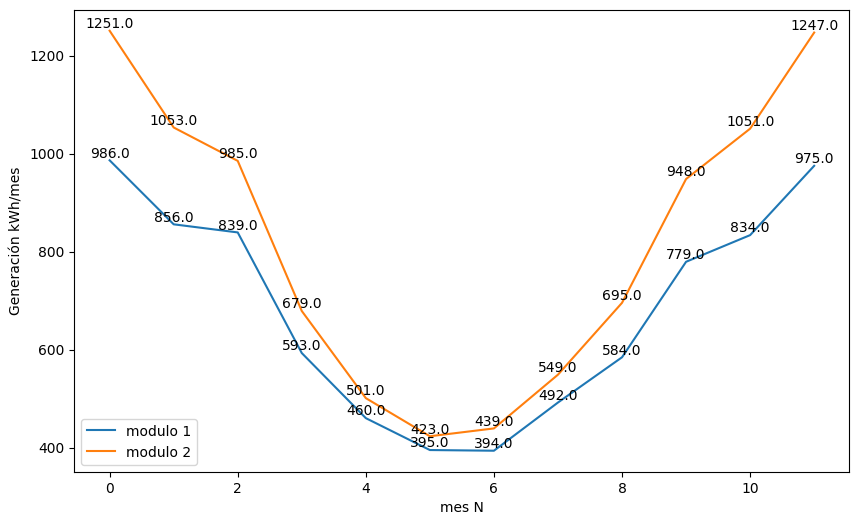

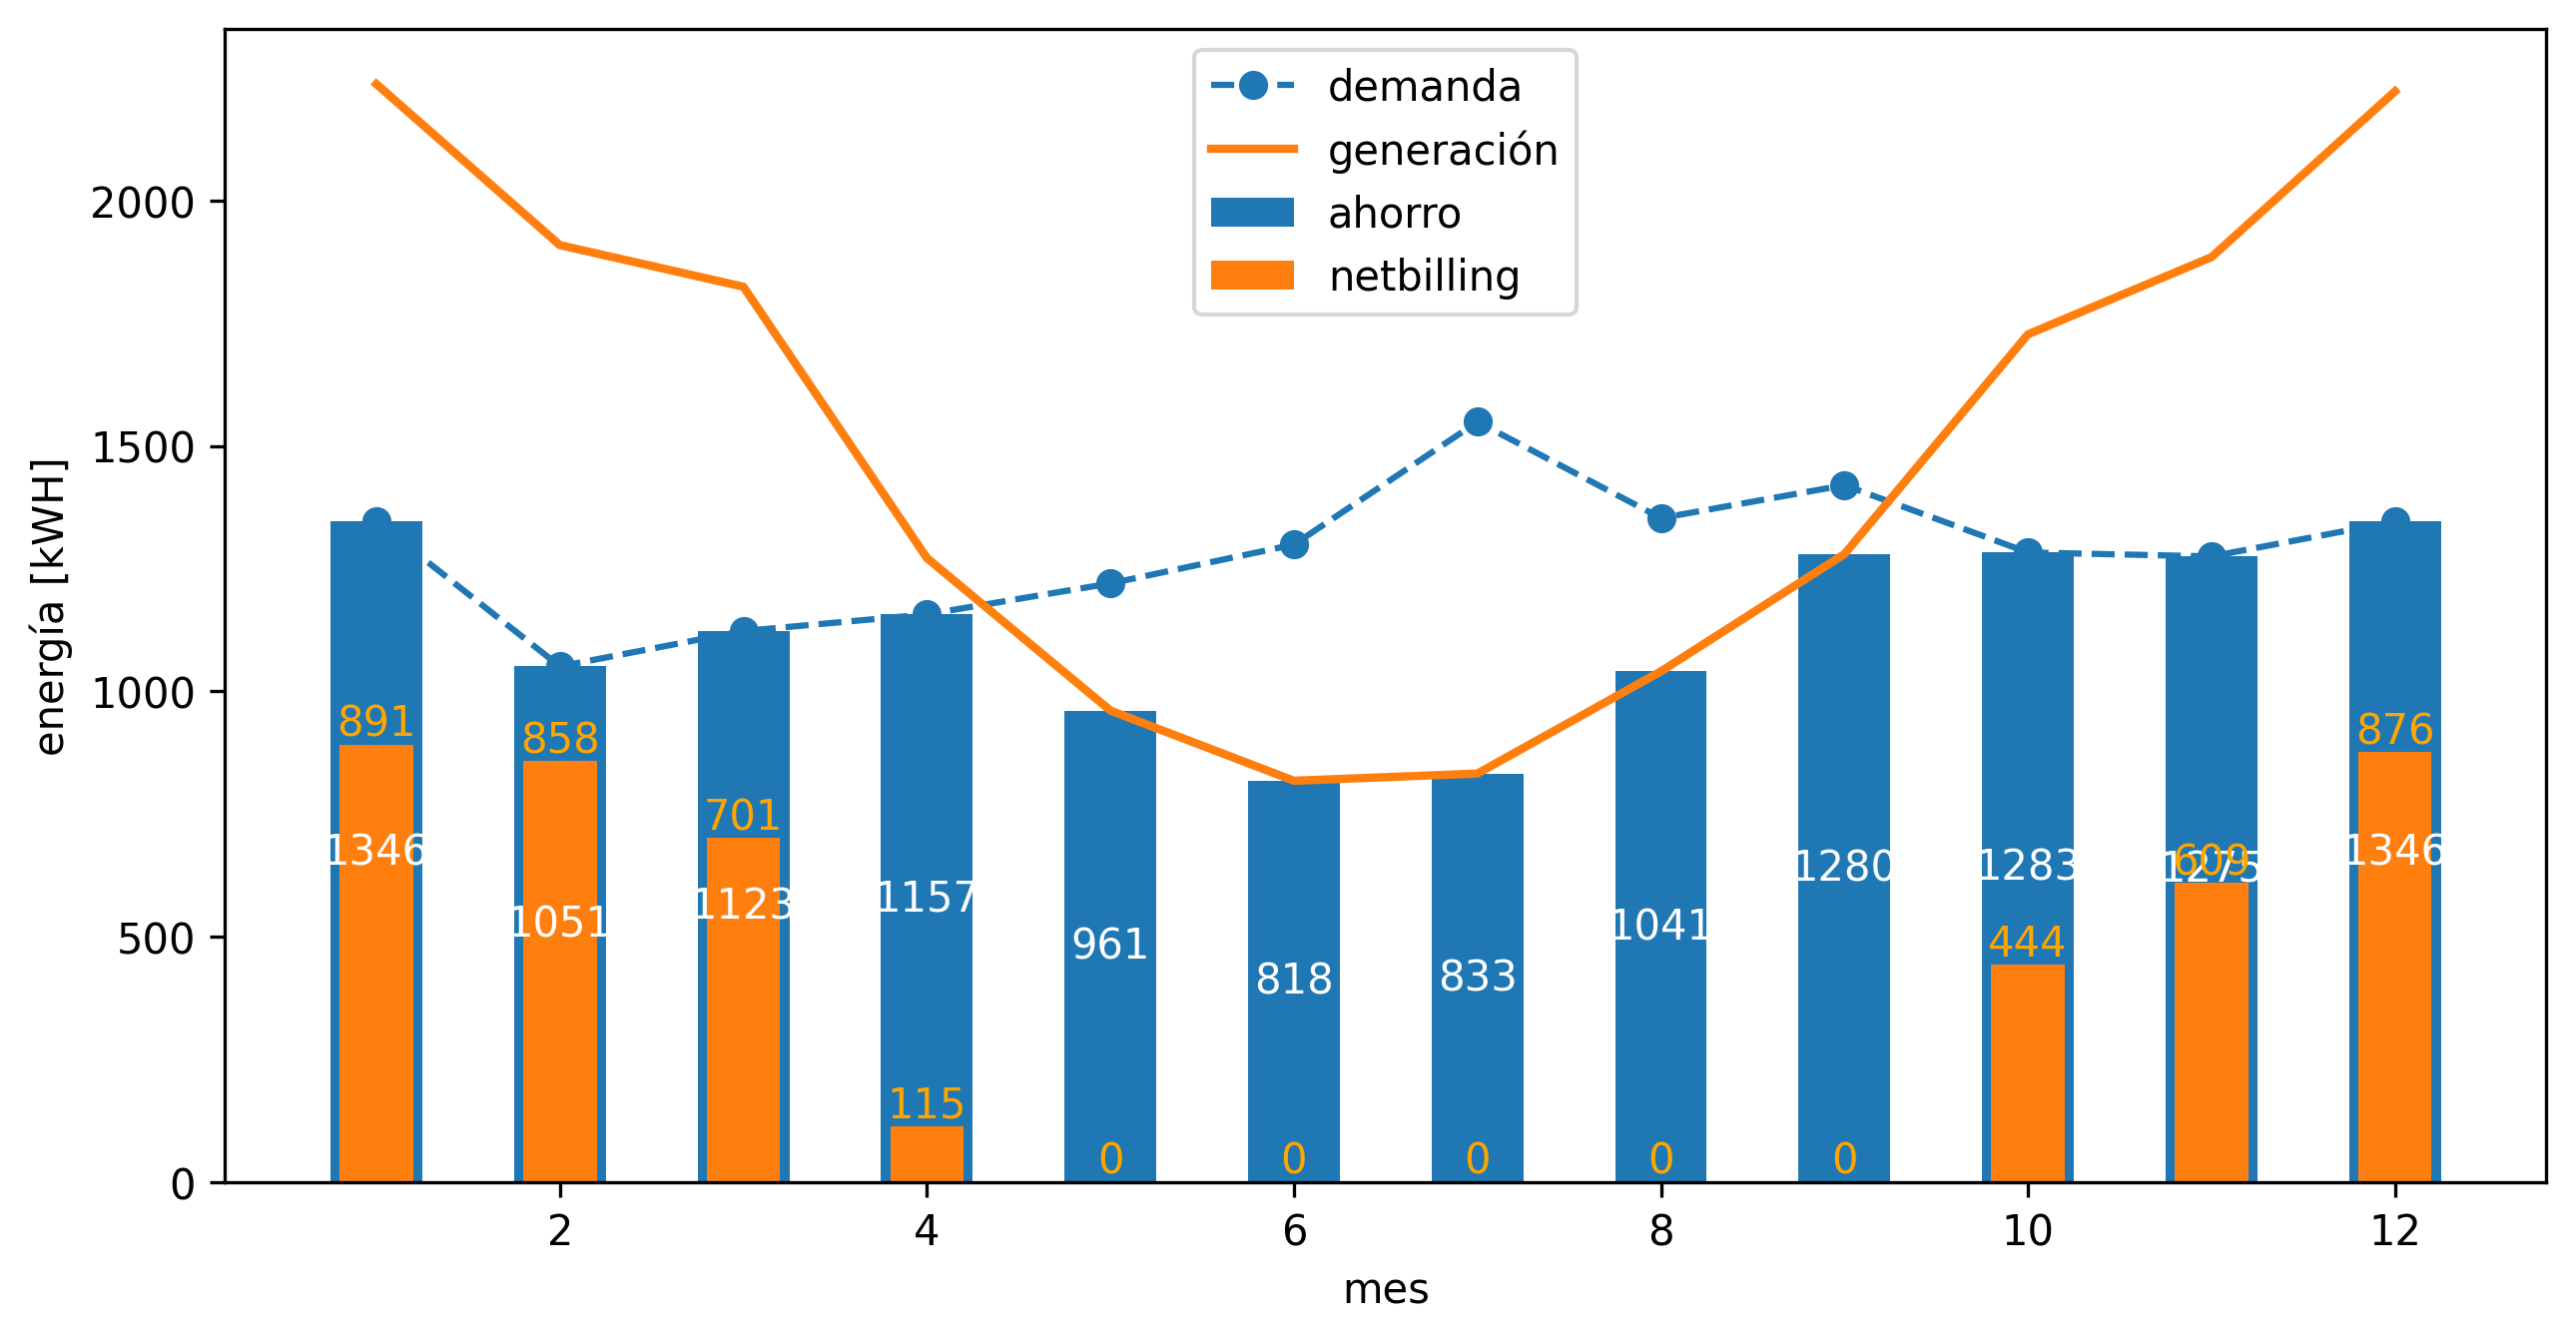

<Figure size 1920x1440 with 0 Axes>

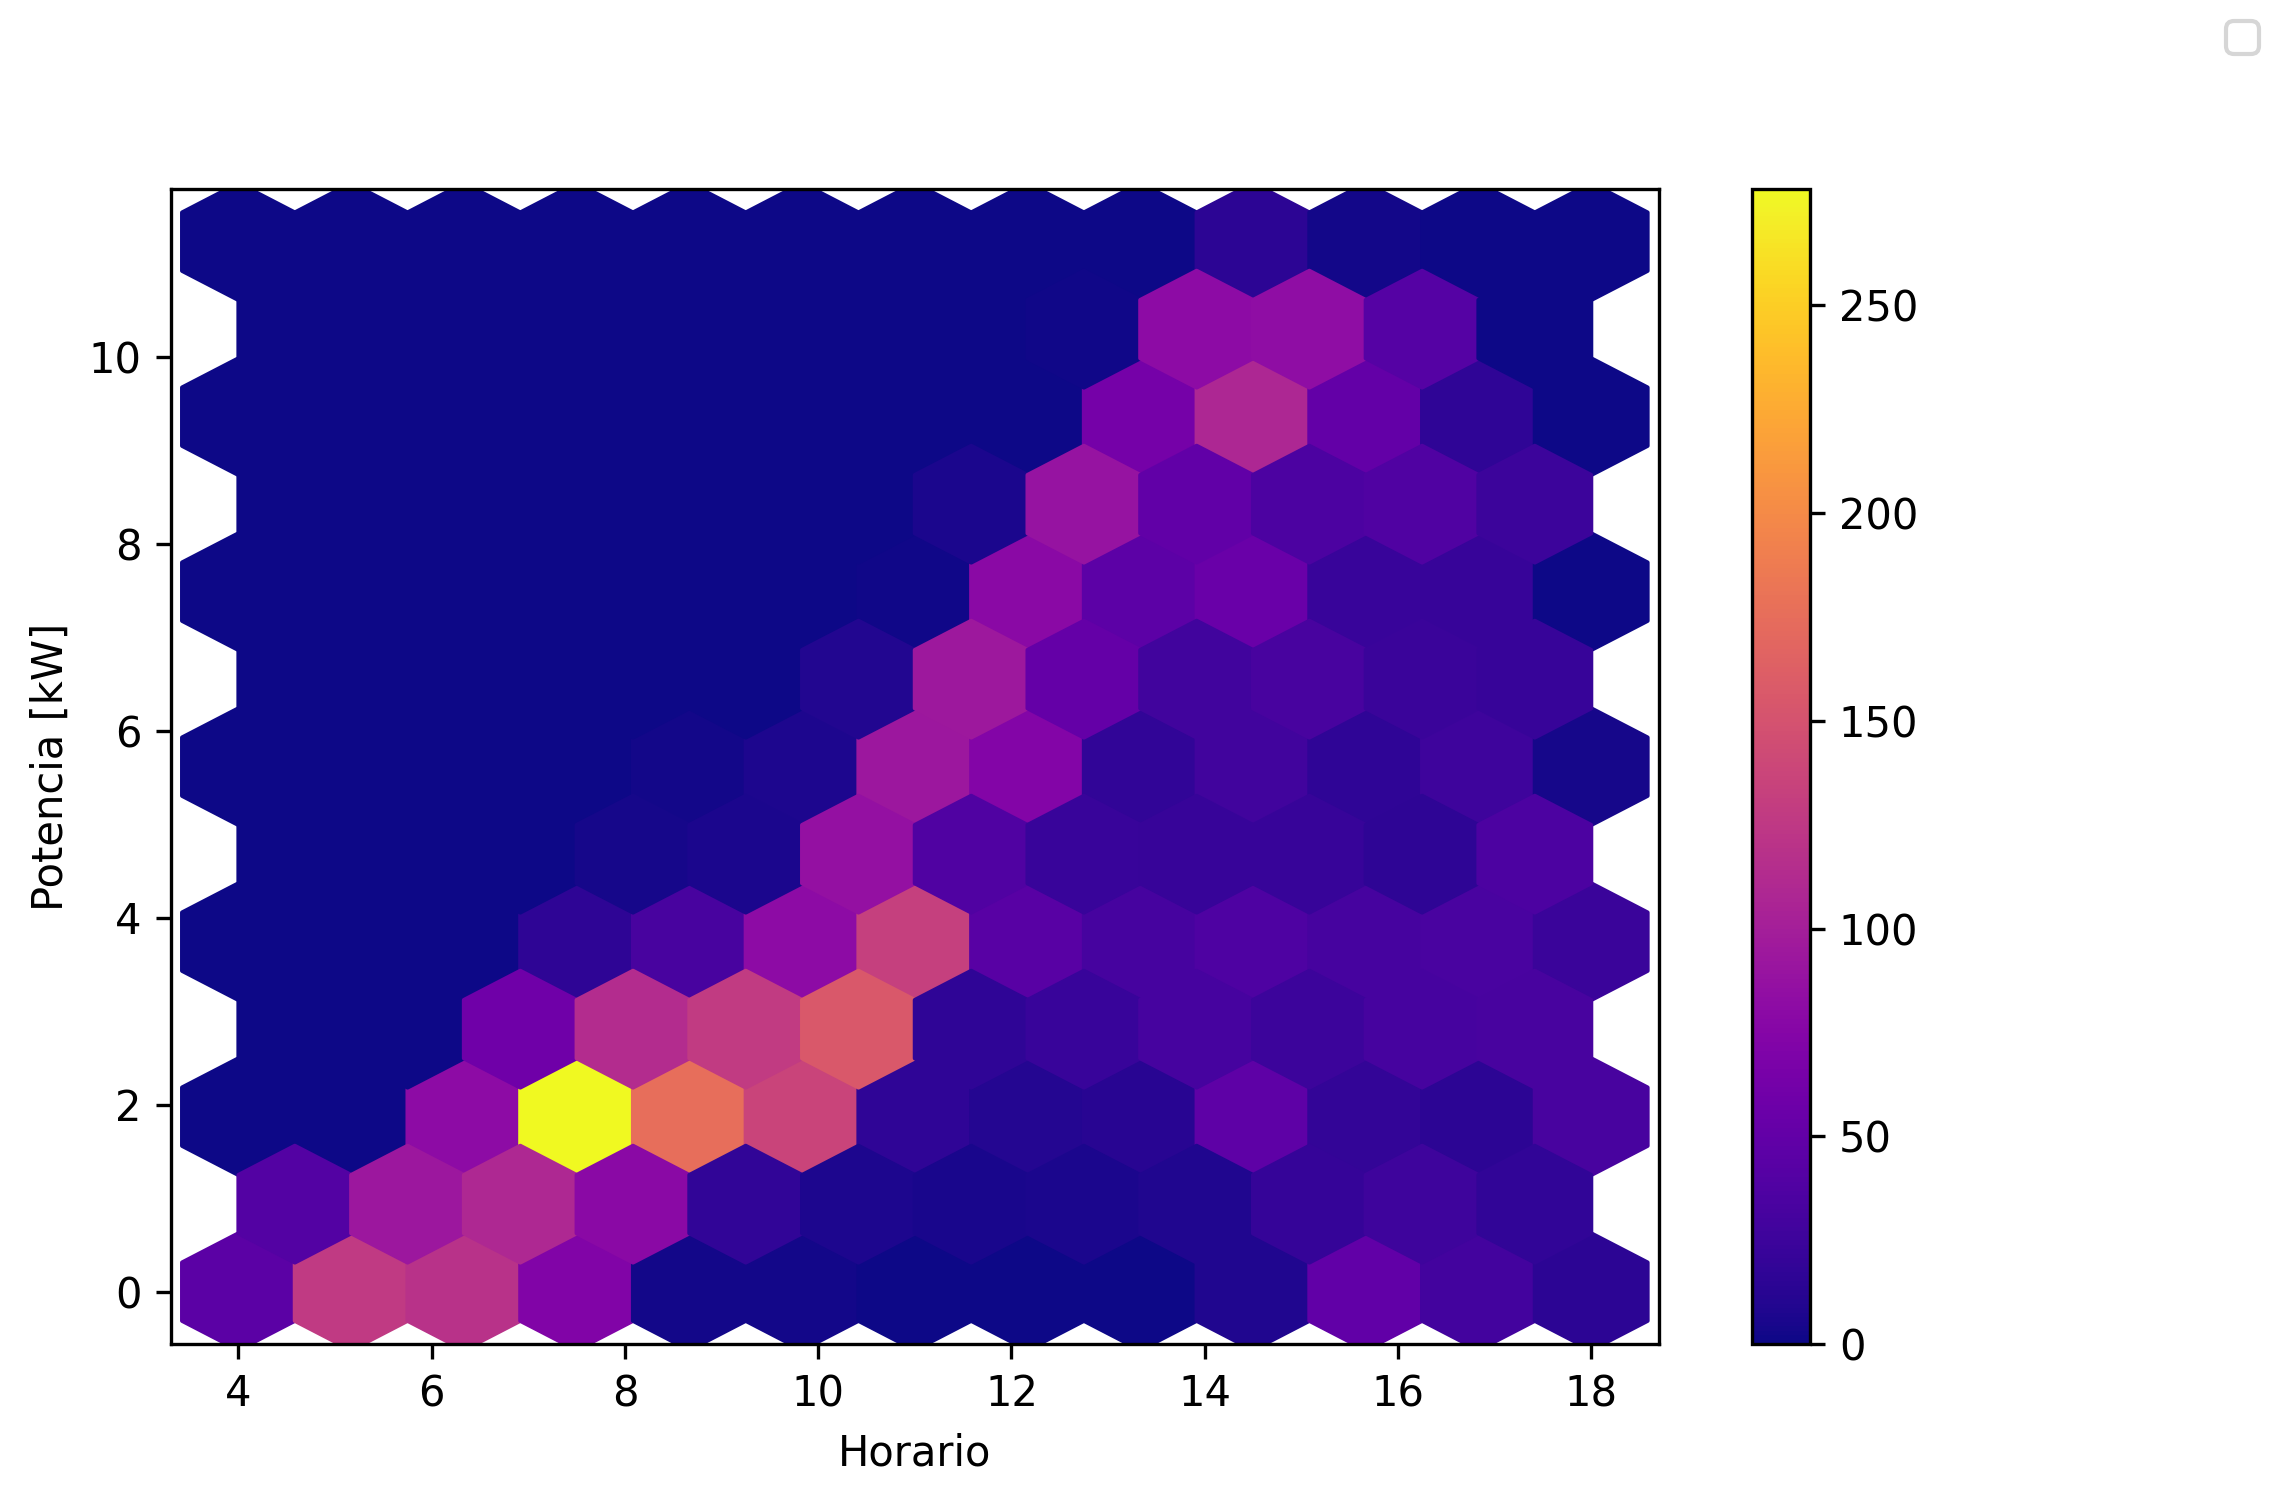

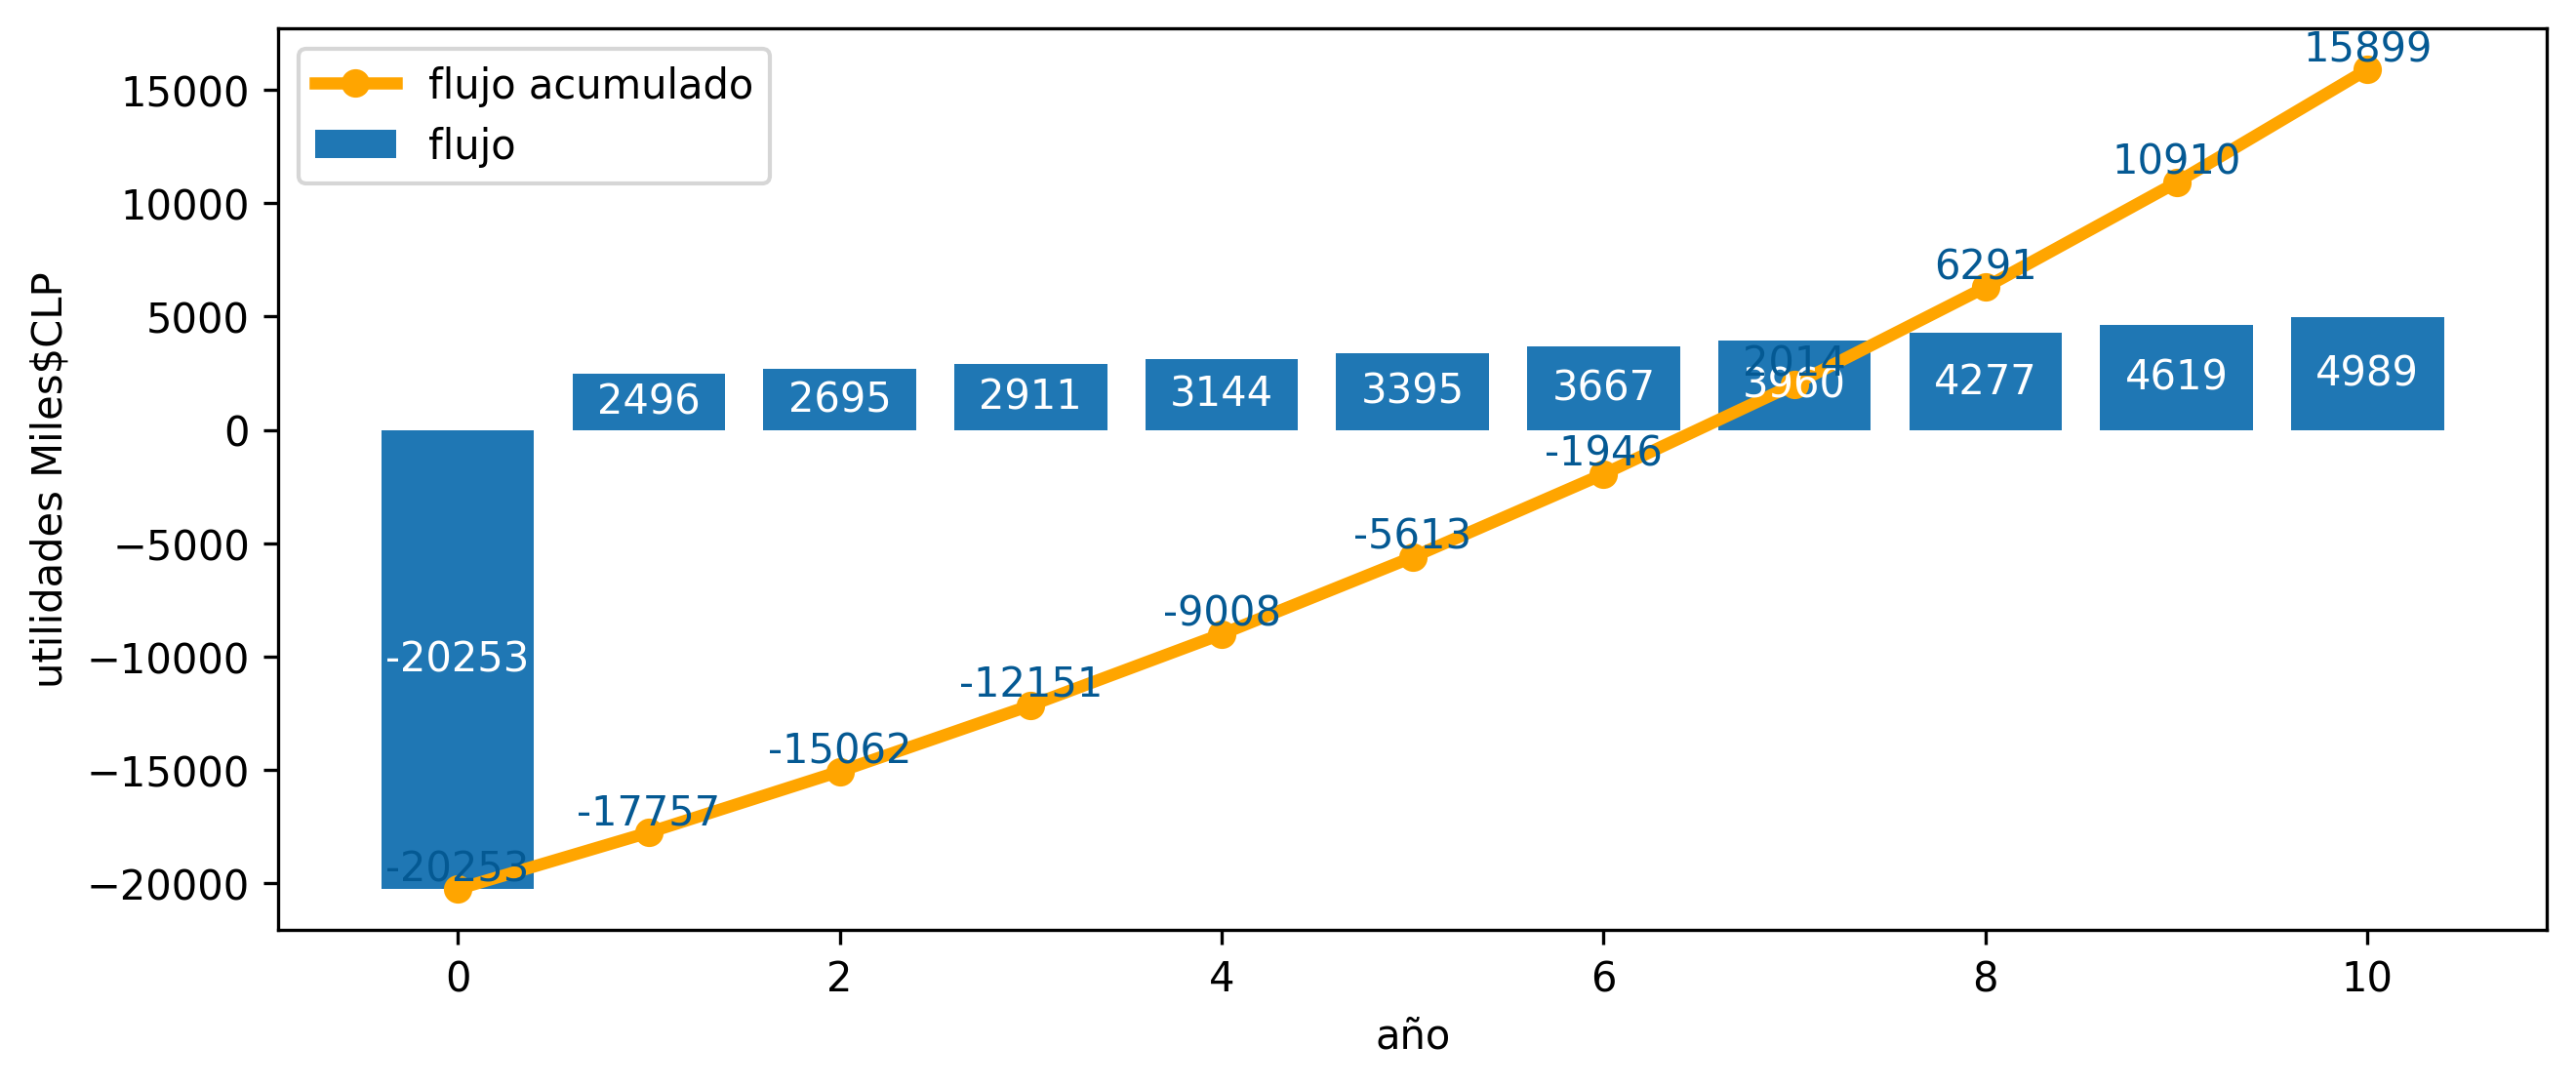

In [18]:
from models.plotter import generate_docs
generate_docs(project)